In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from copy import deepcopy

from pydmd import DMD
from pydmd.bopdmd import BOPDMD
from pydmd.plotter import plot_eigs, plot_summary 

import matplotlib.pyplot as plt

In [2]:
_ = pd.read_csv('cdii.csv').drop(columns=['Unnamed: 0'])
Xn = _.values

t=np.linspace(0, 230, 24)

In [5]:
dmd = DMD(svd_rank=24, tlsq_rank=2, exact=True, opt=True)
dmd.fit(Xn)

Aexa = np.linalg.multi_dot([dmd.modes, np.diag(dmd.eigs), np.linalg.pinv(dmd.modes)])

/usr/local/lib/python3.8/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 2980755177936097.5. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


In [6]:
def hard_threshold(X, gamma=0.01):
    # Hard thresholding for L0 norm.
    X[np.abs(X) ** 2 < 2 * gamma] = 0.0
    return X

def soft_threshold(X, gamma=0.05):
    # Soft thresholding for L1 norm.
    return np.sign(X) * np.maximum(np.abs(X) - gamma, 0.0)

In [7]:
bopdmd = BOPDMD(
    svd_rank=24,
    num_trials=0,
    trial_size=0.8,
    varpro_opts_dict={"verbose":True, "tol":0.8},
    eig_constraints={"imag"},
    use_proj=False,
    mode_proxy=hard_threshold,
    compute_A=True
)

bopdmd.fit(Xn, t)

Step 1 Error 0.2011718136958237 Lambda 1.71437396240152
Convergence reached!


In [11]:
Abop = np.linalg.multi_dot([bopdmd.modes, np.diag(bopdmd.eigs), np.linalg.pinv(bopdmd.modes)])

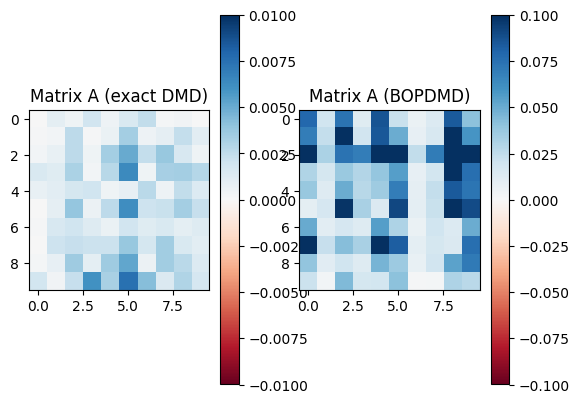

In [12]:
rows = np.random.randint(0,1807,10).reshape(10,1)
cols = np.random.randint(0,1807,10).reshape(1,10)

# Plotting A
plt.subplot(1, 2, 1)
plt.imshow(np.abs(Aexa[rows, cols]), cmap='RdBu', vmin=-0.01, vmax=0.01)
plt.title('Matrix A (exact DMD)')
plt.colorbar()

# Plotting Aexa
plt.subplot(1, 2, 2)
plt.imshow(np.abs(bopdmd.A[rows, cols]), cmap='RdBu', vmin=-0.1, vmax=0.1)
plt.title('Matrix A (BOPDMD)')
plt.colorbar()

plt.show()


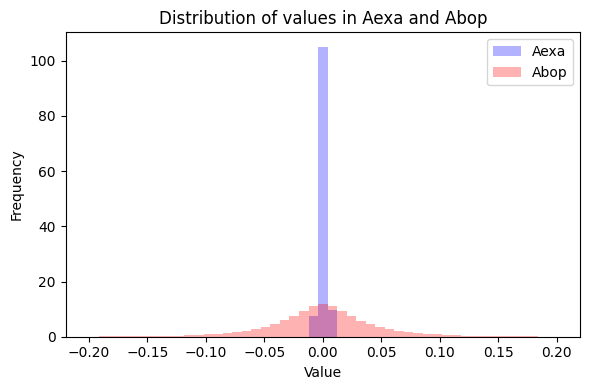

In [23]:
plt.figure(figsize=(6, 4))
plt.hist(Aexa.flatten(), bins=np.linspace(-0.2,0.2,50), color='blue', alpha=0.3, label='Aexa', density=True)
plt.hist(Abop.flatten(), bins=np.linspace(-0.2,0.2,50), color='red', alpha=0.3, label='Abop', density=True)
plt.title('Distribution of values in Aexa and Abop')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()